<a href="https://colab.research.google.com/github/ATHARVA316-DEV/-Eye-Cataract-Detection-1/blob/main/try4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install --quiet timm albumentations opencv-python-headless matplotlib pandas scikit-learn torchmetrics openpyxl
import sys, importlib
packages = ["torch", "timm", "albumentations", "cv2", "matplotlib", "pandas", "sklearn"]
for p in packages:
    try:
        mod = importlib.import_module(p if p!="cv2" else "cv2")
        print(p, getattr(mod, "__version__", "version-ok"))
    except Exception as e:
        print(p, "import error:", e)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 20.3 MB/s eta 0:00:00
torch 2.8.0+cu126
timm 1.0.21
albumentations 2.0.8
cv2 4.12.0
matplotlib 3.10.0
pandas 2.2.2
sklearn 1.6.1


In [9]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/ocular-disease-recognition-odir5k")

print("Path to dataset files:", path)

100%|██████████| 1.62G/1.62G [00:17<00:00, 97.7MB/s]


Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/ocular-disease-recognition-odir5k/versions/2


In [10]:
import os
path="/root/.cache/kagglehub/datasets/andrewmvd/ocular-disease-recognition-odir5k/versions/2"
base_path = path  # ← use the same variable, do NOT rewrite manually

# Show folder structure
for root, dirs, files in os.walk(base_path):
    print(root)
    break

!ls -R "$base_path"


/root/.cache/kagglehub/datasets/andrewmvd/ocular-disease-recognition-odir5k/versions/2
/root/.cache/kagglehub/datasets/andrewmvd/ocular-disease-recognition-odir5k/versions/2:
full_df.csv  ODIR-5K  preprocessed_images

/root/.cache/kagglehub/datasets/andrewmvd/ocular-disease-recognition-odir5k/versions/2/ODIR-5K:
ODIR-5K

/root/.cache/kagglehub/datasets/andrewmvd/ocular-disease-recognition-odir5k/versions/2/ODIR-5K/ODIR-5K:
 data.xlsx  'Testing Images'  'Training Images'

'/root/.cache/kagglehub/datasets/andrewmvd/ocular-disease-recognition-odir5k/versions/2/ODIR-5K/ODIR-5K/Testing Images':
1000_left.jpg	1437_left.jpg	2260_left.jpg	3532_left.jpg	4665_left.jpg
1000_right.jpg	1437_right.jpg	2260_right.jpg	3532_right.jpg	4665_right.jpg
1001_left.jpg	1438_left.jpg	2261_left.jpg	3533_left.jpg	4666_left.jpg
1001_right.jpg	1438_right.jpg	2261_right.jpg	3533_right.jpg	4666_right.jpg
1002_left.jpg	1445_left.jpg	2263_left.jpg	3534_left.jpg	4667_left.jpg
1002_right.jpg	1445_right.jpg	2263_right.jp

In [11]:
import os

base_path = os.path.join(path, "ODIR-5K", "ODIR-5K")

labels_file = os.path.join(base_path, "data.xlsx")
train_images_folder = os.path.join(base_path, "Training Images")
test_images_folder = os.path.join(base_path, "Testing Images")



In [12]:
import pandas as pd

df = pd.read_excel(labels_file)
print(df.head())



   ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   
3   3           66        Male  3_left.jpg  3_right.jpg   
4   4           53        Male  4_left.jpg  4_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                                      normal fundus   
4                        macular epiretinal membrane   

                Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  
0                           normal fundus  0  0  0  1  0  0  0  0  
1                           normal fundus  1  0  0  0  0  0  0  0  
2  moderate non proliferative retinopathy  0  1  0  0  0  0  0  1  
3         branch retinal artery occl

In [13]:
import torch # <-- I've added this line to fix the error
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision.transforms import functional as F

import albumentations as A
from albumentations.pytorch import ToTensorV2

import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, f1_score

# --- Constants ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

IMG_SIZE = 224
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
EPOCHS = 10 # Start with 10, increase if needed

# Disease categories from your 'data.xlsx'
CLASSES = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

Using device: cuda


In [14]:
def preprocess_dataframe(labels_path, images_dir):
    """
    Loads the Excel file and transforms it to treat each eye as a separate sample.
    """
    try:
        df = pd.read_excel(labels_path)
    except FileNotFoundError:
        print(f"Error: Could not find labels file at {labels_path}")
        return pd.DataFrame() # Return empty df
    except Exception as e:
        print(f"Error loading Excel file: {e}")
        return pd.DataFrame()

    # Create two separate dataframes: one for left, one for right
    df_left = df[['Left-Fundus'] + CLASSES].copy()
    df_right = df[['Right-Fundus'] + CLASSES].copy()

    # Rename columns to be consistent
    df_left.rename(columns={'Left-Fundus': 'filename'}, inplace=True)
    df_right.rename(columns={'Right-Fundus': 'filename'}, inplace=True)

    # Add image path
    # This uses the 'images_dir' variable from your setup
    df_left['image_path'] = df_left['filename'].apply(lambda x: os.path.join(images_dir, x))
    df_right['image_path'] = df_right['filename'].apply(lambda x: os.path.join(images_dir, x))

    # Combine them into one single dataframe
    df_combined = pd.concat([df_left, df_right], ignore_index=True)

    # Drop rows where the image file might be missing or entry is bad
    df_combined = df_combined.dropna(subset=['filename'])

    print(f"Original patient count: {len(df)}")
    print(f"Transformed eye count: {len(df_combined)}")

    return df_combined

In [15]:
class EyeDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.image_paths = df['image_path'].values
        self.labels = df[CLASSES].values.astype(np.float32) # Ensure labels are float
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]

        try:
            # Read image using OpenCV
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # Return a dummy image and label if error
            image = np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)
            label = np.zeros(len(CLASSES), dtype=np.float32)
            if self.transforms:
                image = self.transforms(image=image)['image']
            return image, label

        label = self.labels[idx]

        if self.transforms:
            augmented = self.transforms(image=image)
            image = augmented['image']

        return image, label

def get_transforms(is_train=True):
    if is_train:
        return A.Compose([
            A.Resize(IMG_SIZE, IMG_SIZE),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.Rotate(limit=15, p=0.3),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])
    else:
        return A.Compose([
            A.Resize(IMG_SIZE, IMG_SIZE),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])


In [16]:
def get_model(num_classes=8):
    """
    Loads a pre-trained ResNet-50 and replaces the final layer.
    """
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

    # Replace the final fully connected layer
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

    return model

In [17]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

def validate_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)

            # Get predictions (apply sigmoid and threshold)
            preds = torch.sigmoid(outputs) > 0.5

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)

    # Calculate metrics
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Calculate F1 score (micro-average)
    f1 = f1_score(all_labels, all_preds, average='micro')

    return epoch_loss, f1

In [18]:
class GradCAM:
    """
    Implementation of Grad-CAM to visualize model activations.
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        self.target_layer.register_forward_hook(self._save_activations)
        self.target_layer.register_backward_hook(self._save_gradients)

    def _save_activations(self, module, input, output):
        self.activations = output

    def _save_gradients(self, module, grad_in, grad_out):
        self.gradients = grad_out[0]

    def __call__(self, x, class_idx=None):
        # Forward pass
        self.model.eval()
        output = self.model(x)

        if class_idx is None:
            # Use the class with the highest score
            class_idx = torch.argmax(output, dim=1).item()

        # Zero gradients
        self.model.zero_grad()

        # Backward pass for the target class
        target = torch.zeros_like(output)
        target[0, class_idx] = 1
        output.backward(gradient=target, retain_graph=True)

        # Get gradients and activations
        gradients = self.gradients
        activations = self.activations

        # Pool gradients
        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

        # Weight activations
        for i in range(activations.shape[1]):
            activations[:, i, :, :] *= pooled_gradients[i]

        # Average weighted activations
        heatmap = torch.mean(activations, dim=1).squeeze()

        # ReLU
        heatmap = nn.functional.relu(heatmap)

        # Normalize
        heatmap /= torch.max(heatmap)

        return heatmap.cpu().detach().numpy()

def show_grad_cam(model, target_layer, img_tensor, original_img, class_idx=None, class_name=""):
    """
    Generates and plots the Grad-CAM heatmap.
    """
    # Get heatmap
    gc = GradCAM(model, target_layer)
    heatmap = gc(img_tensor.unsqueeze(0).to(DEVICE), class_idx)

    # Resize heatmap to original image size
    heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))

    # Normalize heatmap
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))

    # Apply colormap
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

    # Superimpose heatmap on original image
    superimposed_img = np.uint8(heatmap_colored * 0.4 + original_img * 0.6)

    # Plot
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(original_img)
    axs[0].set_title("Original.png")
    axs[0].axis('off')

    axs[1].imshow(heatmap_colored)
    axs[1].set_title(f"Grad-CAM Heatmap ({class_name})")
    axs[1].axis('off')

    axs[2].imshow(superimposed_img)
    axs[2].set_title("Overlay")
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()


In [19]:
# This uses the 'labels_file' and 'train_images_folder' from your setup
df = preprocess_dataframe(labels_file, train_images_folder)

if df.empty:
    print("Dataframe is empty. Check your paths and file.")
else:
    # Split data
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
    print(f"Data split: {len(train_df)} train, {len(val_df)} validation samples")

Original patient count: 3500
Transformed eye count: 7000
Data split: 5600 train, 1400 validation samples


In [20]:
train_dataset = EyeDataset(train_df, transforms=get_transforms(is_train=True))
val_dataset = EyeDataset(val_df, transforms=get_transforms(is_train=False))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

model = get_model(num_classes=len(CLASSES)).to(DEVICE)

# Multi-label classification requires BCEWithLogitsLoss
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 88.4MB/s]


In [21]:
best_f1 = 0.0
print("\n--- Starting Training ---")
for epoch in range(EPOCHS):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_f1 = validate_one_epoch(model, val_loader, criterion, DEVICE)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"New best model saved with F1: {best_f1:.4f}")

print("--- Training Finished ---")


--- Starting Training ---
Epoch 1/10 | Train Loss: 0.3416 | Val Loss: 0.2924 | Val F1: 0.3436
New best model saved with F1: 0.3436
Epoch 2/10 | Train Loss: 0.2804 | Val Loss: 0.2764 | Val F1: 0.4007
New best model saved with F1: 0.4007
Epoch 3/10 | Train Loss: 0.2535 | Val Loss: 0.2736 | Val F1: 0.4656
New best model saved with F1: 0.4656
Epoch 4/10 | Train Loss: 0.2289 | Val Loss: 0.2835 | Val F1: 0.4930
New best model saved with F1: 0.4930
Epoch 5/10 | Train Loss: 0.2015 | Val Loss: 0.2969 | Val F1: 0.4859
Epoch 6/10 | Train Loss: 0.1727 | Val Loss: 0.3198 | Val F1: 0.5134
New best model saved with F1: 0.5134
Epoch 7/10 | Train Loss: 0.1453 | Val Loss: 0.3243 | Val F1: 0.5289
New best model saved with F1: 0.5289
Epoch 8/10 | Train Loss: 0.1241 | Val Loss: 0.3617 | Val F1: 0.5164
Epoch 9/10 | Train Loss: 0.1038 | Val Loss: 0.3499 | Val F1: 0.5423
New best model saved with F1: 0.5423
Epoch 10/10 | Train Loss: 0.0896 | Val Loss: 0.3827 | Val F1: 0.5418
--- Training Finished ---



Loading best model for Grad-CAM analysis...

--- Grad-CAM Analysis ---
Image: /root/.cache/kagglehub/datasets/andrewmvd/ocular-disease-recognition-odir5k/versions/2/ODIR-5K/ODIR-5K/Training Images/132_left.jpg
True Labels:
  - O

Model Predictions (Probabilities):
  - N: 0.1475
  - D: 0.8253
  - G: 0.0021
  - C: 0.0053
  - A: 0.0717
  - H: 0.0024
  - M: 0.0108
  - O: 0.1452

Generating Grad-CAM for predicted class: 'D' (index 1)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


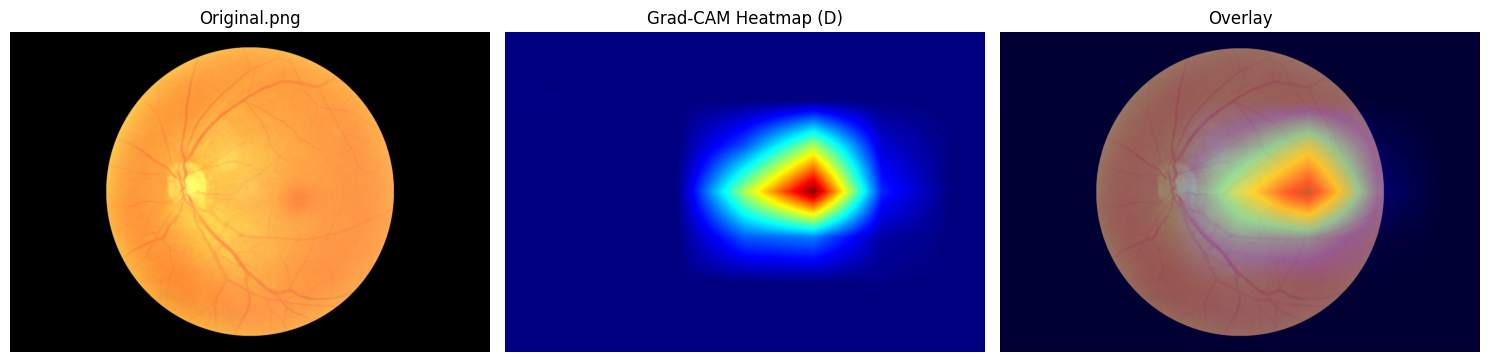

In [22]:
print("\nLoading best model for Grad-CAM analysis...")
model.load_state_dict(torch.load('best_model.pth'))
model.to(DEVICE).eval()

# 7. Generate Grad-CAM for a sample image
# Get a sample from the validation set
sample_idx = 10 # You can change this index to see other images

# Get data from dataset (which applies val transforms)
img_tensor, label = val_dataset[sample_idx]

# Get original image (for plotting)
original_img_path = val_dataset.image_paths[sample_idx]
original_img = cv2.imread(original_img_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# Get model prediction
with torch.no_grad():
    output = model(img_tensor.unsqueeze(0).to(DEVICE))
    probs = torch.sigmoid(output).cpu().numpy()[0]

print("\n--- Grad-CAM Analysis ---")
print(f"Image: {original_img_path}")
print("True Labels:")
for i, class_name in enumerate(CLASSES):
    if label[i] == 1:
        print(f"  - {class_name}")

print("\nModel Predictions (Probabilities):")
pred_indices = np.where(probs > 0.5)[0]
if len(pred_indices) == 0:
    print("  - Model predicts no abnormalities (or 'Normal' if N prob > 0.5)")
    pred_idx = np.argmax(probs) # Get highest prob class even if < 0.5
else:
    pred_idx = pred_indices[0] # Just pick the first predicted class for Grad-CAM

for i, class_name in enumerate(CLASSES):
    print(f"  - {class_name}: {probs[i]:.4f}")

# --- Generate Grad-CAM ---
# We target the final convolutional block of ResNet-50
target_layer = model.layer4[-1]

# Get the class name for the prediction we're visualizing
pred_class_name = CLASSES[pred_idx]

print(f"\nGenerating Grad-CAM for predicted class: '{pred_class_name}' (index {pred_idx})")

show_grad_cam(
    model=model,
    target_layer=target_layer,
    img_tensor=img_tensor,
    original_img=original_img,
    class_idx=pred_idx,
    class_name=pred_class_name
)
